### 📥 Load the Wine Quality Dataset

We start by loading the **Wine Quality** dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/), using the `fetch_ucirepo` function. This dataset contains physicochemical properties of red and white wines, along with a quality score (typically between 0 and 10) assigned by wine taster

- X contains the input features (e.g., acidity, sugar, alcohol).

- y contains the target variable (wine quality score).s.


In [1]:
from ucimlrepo import fetch_ucirepo
import sys
import os
sys.path.append(os.path.abspath('..'))
from dropkan.DropKAN import DropKAN
from dropkan.DropKANLayer import DropKANLayer
import torch
import torch.nn as nn
import numpy as np
import random
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def set_training_mode(module, mode):
    """Set the training mode for a module and all its sub-modules."""
    module.training = mode
    for submodule in module.children():
        set_training_mode(submodule, mode)

In [2]:
wine_quality = fetch_ucirepo(id=186) 
  
X = wine_quality.data.features 
y = wine_quality.data.targets 


### 🧪 Train-Test Split & Feature Scaling

We split the dataset into training and testing sets using an 60/40 split. A fixed `random_state` is used to ensure reproducibility.

After splitting, we apply **standardization** to the features using `StandardScaler`, which transforms the data to have zero mean and unit variance. 


We prepare the dataset for training by converting the NumPy arrays (from `scikit-learn`) into PyTorch tensors. This is required for compatibility with PyTorch-based models like KAN and DropKAN.


In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)        

dataset = {}
dataset['train_input'] = torch.from_numpy(X_train).float()
dataset['test_input'] = torch.from_numpy(X_test).float()
dataset['train_label'] = torch.from_numpy(y_train.values)
dataset['test_label'] = torch.from_numpy(y_test.values)


### 🚀 Training and Evaluating KAN, KAN + Dropout, and DropKAN Models

We train three variants of the Kolmogorov-Arnold Network (KAN) on the Wine Quality dataset:

- **KAN**: The baseline model without dropout.
- **KAN + Dropout**: Applies dropout during training with a drop rate of 0.1.
- **DropKAN**: Uses the DropKAN dropout mode with the same drop rate.

For each model:
- We train 5 independent runs with different random seeds for robustness.
- Use the Adam optimizer, L1 loss, a batch size of 32, and a learning rate oWe train each model for 10 epochsataset size.
- After training, the model is evaluated on the test set, and Mean Absolute Error (MAE) is recorded.


In [4]:
# Initialize results DataFrame
log_df = pd.DataFrame(columns=['drop_rate', 'mode', 'mae'])

# Define number of steps
epochs = 10
batch = 32
steps = int(len(X_train) / batch) * epochs

# ---- Train plain KAN (no dropout) ----
for j in range(5):
    model = DropKAN(seed=j, width=[X_train.shape[1], X_train.shape[1]*2, 1])

    model.train(dataset, opt="Adam", steps=steps, batch=batch, lr=0.01, loss_fn=torch.nn.L1Loss())
    set_training_mode(model, False)

    y_pred = model(dataset['test_input']).detach().numpy()
    mae = mean_absolute_error(y_test, y_pred)
    print(f"mode=KAN | test={mae:.4f}")
    log_df.loc[len(log_df)] = [0.0, 'KAN', mae]

# ---- Train KAN + Dropout and DropKAN at drop_rate=0.1 ----
drop_rate = 0.3
for j in range(5):
    # KAN + Dropout
    model = DropKAN(seed=j, width=[X_train.shape[1], X_train.shape[1]*2, 1], drop_rate=drop_rate, drop_mode='dropout')

    model.train(dataset, opt="Adam", steps=steps, batch=batch, lr=0.01, loss_fn=torch.nn.L1Loss())
    set_training_mode(model, False)

    y_pred = model(dataset['test_input']).detach().numpy()
    mae = mean_absolute_error(y_test, y_pred)
    print(f"mode=KAN + Dropout | test={mae:.4f}")
    log_df.loc[len(log_df)] = [drop_rate, 'KAN + Dropout', mae]

    # DropKAN
    model = DropKAN(seed=j, width=[X_train.shape[1], X_train.shape[1]*2, 1], drop_rate=drop_rate, drop_mode='postact')

    model.train(dataset, opt="Adam", steps=steps, batch=batch, lr=0.01, loss_fn=torch.nn.L1Loss())
    set_training_mode(model, False)

    y_pred = model(dataset['test_input']).detach().numpy()
    mae = mean_absolute_error(y_test, y_pred)
    print(f"mode=DropKAN | test={mae:.4f}")
    log_df.loc[len(log_df)] = [drop_rate, 'DropKAN', mae]



description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 164.79it/s]


mode=KAN | test=0.5577


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 179.10it/s]


mode=KAN | test=0.5797


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 178.02it/s]


mode=KAN | test=0.5552


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 179.82it/s]


mode=KAN | test=0.5556


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 179.21it/s]


mode=KAN | test=0.5426


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 178.27it/s]


mode=KAN + Dropout | test=0.5444


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:10<00:00, 150.86it/s]


mode=DropKAN | test=0.5662


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 175.65it/s]


mode=KAN + Dropout | test=0.5620


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:10<00:00, 151.20it/s]


mode=DropKAN | test=0.5777


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 174.25it/s]


mode=KAN + Dropout | test=0.5444


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:10<00:00, 151.56it/s]


mode=DropKAN | test=0.5559


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 175.84it/s]


mode=KAN + Dropout | test=0.5310


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:10<00:00, 151.56it/s]


mode=DropKAN | test=0.6124


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:09<00:00, 176.31it/s]


mode=KAN + Dropout | test=0.5462


description: 100%|█████████████████████████████████████████████| 1620/1620 [00:10<00:00, 151.73it/s]


mode=DropKAN | test=0.5574


### 📊 Box Plot Comparison of Test MAE Across Models

We visualize the distribution of Mean Absolute Errors (MAE) obtained from multiple runs of each model variant using a box plot. This allows us to compare the predictive performance of:

- **KAN** (no dropout)
- **KAN + Dropout**
- **DropKAN**

The plot highlights the variability and median performance of each approach at the specified dropout rate.


<Figure size 800x600 with 0 Axes>

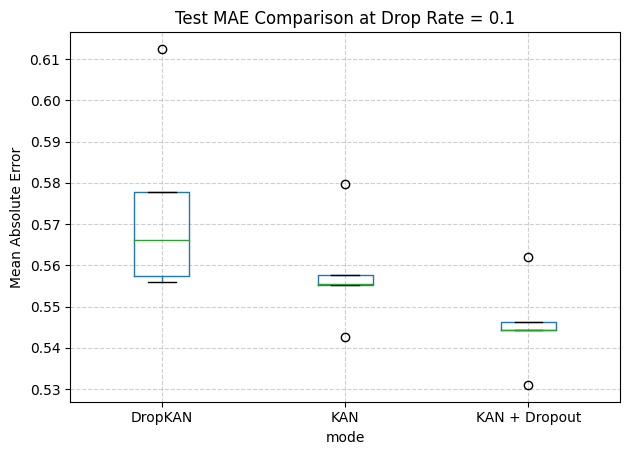

In [5]:
# ---- Box plot ----
plt.figure(figsize=(8, 6))
log_df.boxplot(column='mae', by='mode')
plt.title("Test MAE Comparison at Drop Rate = 0.1")
plt.suptitle("")
plt.ylabel("Mean Absolute Error")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
